In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# !pip install ultralytics --upgrade

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import cv2
from utils_ import *

In [25]:
model_path = r"F:\Master\S4\main\backend\best.pt"
model = YOLO(model_path)

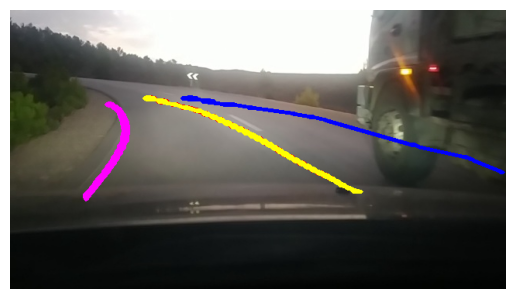

{0: 'line1', 1: 'line2', 2: 'line3'}

In [8]:
import cv2
import matplotlib.pyplot as plt
def read_rgb(path):
  return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
def test_image(model,image,verbose=False):
  result =  model.predict(image,verbose=verbose)
  return result[0]#.masks.data.cpu().permute(1,2,0)
def test_image_from_path(model,image):
  if isinstance(image,str):image = read_rgb(path)
  return test_image(model,image)
def show_img(image,figsize=None,**args):
  if figsize is not None:
    plt.figure(figsize=figsize)
  plt.imshow(image,**args)
  plt.axis("off")
  plt.show()
def draw_masks_on_image(image,lines,color=255):
  for line in lines:
      prev = None
      for x,y in line:
          curr = int(x),int(y)
          if prev is not None:
              cv2.line(image,prev,curr,color,4)
          prev = curr
  return image
def draw_mask(image,data,color=255):
  o = np.where(data!=0)
  return draw_masks_on_image(image,[zip(*o[::-1])],color=color)
path = r"F:\Master\S4\yolo_test\vids\projet3\projet3_490.jpg"
# path = r"f:\Master\S4\yolo_test\vids\projet11\projet11_74_augmented.jpg"
res = test_image_from_path(model,path)
target = np.clip(res.masks.data.sum(0),0,1)
# show_img(target,cmap='gray')
target = res.orig_img.copy()
colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255)]
for i,data in enumerate(res.masks.data[:]):
  draw_mask(target,data,colors[i]) 
show_img(target,cmap='gray')
res.names

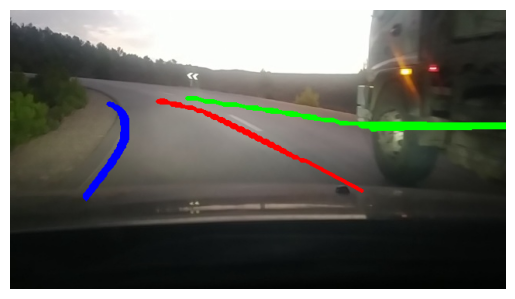

{0: 'line'}

In [11]:
model_path = r"F:\Master\S4\main\backend\models\train4\best.pt"
model = YOLO(model_path)

path = r"F:\Master\S4\yolo_test\vids\projet3\projet3_490.jpg"
# path = r"f:\Master\S4\yolo_test\vids\projet11\projet11_74_augmented.jpg"
res = test_image_from_path(model,path)
target = np.clip(res.masks.data.sum(0),0,1)
# show_img(target,cmap='gray')
target = res.orig_img.copy()
colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255)]
for i,data in enumerate(res.masks.data[:]):
  draw_mask(target,data,colors[i]) 
show_img(target,cmap='gray')
res.names

In [74]:


def get_curvatures2(masks, indexes, step=3,range=[1,-2]):
    left,right,ys=[],[],[]
    mid = []

    l,r = range
    for i, line in enumerate(masks[::step]):
        i = i * step
        ind1 = np.where(line == indexes[0])
        ind2 = np.where(line == indexes[1])
        ind1 = ind1[0]
        ind2 = ind2[0]
        if len(ind1) <= (l+1)*2 or len(ind2) <= (l+1)*2:
            continue
        mid1 = (ind1[l]+ind1[r])//2
        mid2 = (ind2[l]+ind2[r])//2
        left.append(mid1)
        right.append(mid2)

        ys.append(i)

        mid.append(((mid1+mid2)//2,i))
    return left, right, ys,mid

def draw_lane_zone_transp(image, left, right, ys, opacity=.75, color=(0, 1, 0)):
    mask = draw_lane_zone(np.zeros_like(image),(right,left),ys,step=5).astype(np.float64)
    mask /= 255.0
    mask *= opacity
    green = np.ones(image.shape, dtype=np.float64)*color
    return green*mask + (image/255)*(1.0-mask)
def trigger_warning(diffn,s=None):
    import time
    if s is None:
        from sound import Sound
        s = Sound()
    s.start()
    print("Warning: Lane Departure Detected!")
    time.sleep(3)
    s.stop()
def lane_departure_warning(left_lane, right_lane, car_center, threshold, height, trigger_sound=False, img=None):
    lane_center = (left_lane + right_lane) // 2
    lateral_position = abs(car_center - lane_center)
    in_lane = lateral_position < threshold

    if img is not None:
        h,w = img.shape[:2]
        ccr = car_center+threshold
        ccl = car_center-threshold
        ht = h-40
        hm = h-50
        hb = h-60

        cv2.line(img, (ccr, hm),(ccl, hm), 0, 5)
        cv2.line(img, (ccr, hb),(ccr, ht), 0, 5)
        cv2.line(img, (ccl, hb),(ccl, ht), 0, 5)
        cv2.circle(img, (car_center, hm), 7, 0, -1)

        c = GREEN if in_lane else RED
        cv2.circle(img, (lane_center, height), 10, c, -1)
    return trigger_sound and not in_lane
    # return lateral_position
def draw_direction(img, points, *args, type="dots", step=1):
    prev = None
    for x, y in list(points)[::step]:
        curr = int(x), int(y)
        if prev is not None:
            if type == "line":
                cv2.line(img, prev, curr, *args)
            if type == "dots":
                cv2.circle(img, curr, *args)
        prev = curr
    if type == "arrow":
        cv2.arrowedLine(img, points[1], points[0],  *args, tipLength=2)


In [103]:
def get_lines(data):
    lines = []
    maxes = []
    for i,d in enumerate(data):
        o = np.where(d!=0)
        max_h ,max_w= o[0].max(),o[1].max()
        maxes.append([i,max_w])
        lines.append(o)
    maxes = sorted(maxes,key=(lambda m:m[1]))
    return [lines[i] for i,_ in maxes]
video = r"F:\Master\S4\yolo_test\vids\projet11.mp4"
video = cv2.VideoCapture(video)
# seek_video(video,20)

on,frame = video.read()
frame = cv2.resize(frame,(640,384))

h,w = frame.shape[:2]
LANE_THRESHOLD = 90
CAR_CENTER = w//2
warning_on = False
from sound import Sound
s = Sound(filepath=r"F:\Master\S4\main\rsrc\Alarm-beeping-sound.wav",delai=.1)


try:
    while on:
        # frame=  cv2.rotate(frame,2)
        frame = cv2.resize(frame,(640,384))

        res = test_image_from_path(model,frame)
        if res.masks:
            # print("lines",res.masks.data.shape[0],len(res.boxes.cls))
            # frame = draw_masks_on_image(target,res.masks.xy)
            lines = get_lines(res.masks.data[:3])
            mask = np.zeros(frame.shape[:2])
            colors = [1,2,3]
            for i,o in enumerate(lines):
                draw_masks_on_image(mask,[zip(*o[::-1])],color=i)
            # frame = mask
            # masks = keep_red(frame)
            left, right, ys,dirs = get_curvatures2(mask,[1,2],1,range=[0,-1])
            out = draw_lane_zone_transp(frame, left, right, ys, opacity=.30, color=(0, 1, 0))
            warning_on = lane_departure_warning(left[-1], right[-1],CAR_CENTER, LANE_THRESHOLD, ys[-1], trigger_sound=True,img=out)
            if warning_on:
                s.start()
            if not warning_on:
                s.stop()


            # frame = mask
            frame = out
        cv2.imshow("main",frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        on,frame = video.read()
except Exception as e:
    video.release()
    cv2.destroyAllWindows()
    raise e
video.release()
cv2.destroyAllWindows()

In [ ]:
help(res.ploxt)

In [ ]:
def draw_lines_from_array(img,arr,color,thickness=2,radius=2):
  print("Found",len(arr),"lanes")
  for line in arr:
    prev = None
    for x,y in line:
      curr = int(x),int(y)
      # if prev is not None: cv2.line(img,prev,curr,color,2,thickness)
      cv2.circle(img,curr,radius,color,thickness)
      prev = curr
  return img
def draw_lines_from_text(img,text_content,color=255):
  h,w = img.shape[:2]
  lines = [np.array([float(a) for a in line[2:].split(" ")]).reshape(-1,2) for line in text_content.splitlines()]
  lines = [(line * (w,h)).astype(int) for line in lines]
  return draw_lines_from_array(img,lines,color)
def draw_lines_from_yolo_res(image,res,color=100,thickness=2,radius=2):
  if len(res)==0 or (not hasattr(res[0].masks,"xy")):
    return None
  lines = res[0].masks.xy
  return draw_lines_from_array(image,lines,color,thickness=thickness,radius=radius)

def predict(model,img,target=None,thickness=2,radius=2):
  res = model.predict(img,verbose=False)
  if target is None:target = img
  return draw_lines_from_yolo_res(target,res,color=(255,0,0),thickness=thickness,radius=radius)
def test_image(image_path,model,figsize=(6,6)):
  img = cv2.imread(image_path)
  img = predict(model,img)
  plt.imshow(img)
  plt.axis("off")
  plt.show()
# test_image("C:/Users/PyCy/Desktop/mrirt.png",model)


In [ ]:
from utils_ import init_polygon,seek_video,draw_polygon,mask_road
import time

def read_video(video,flip=None,resize=None):
    on,frame = video.read()
    if on:
        if resize: frame = cv2.resize(frame,resize)
        if flip : frame = cv2.rotate(frame,flip)
    return on,frame

In [ ]:
config = {
    "polygon_height": .5,

    "lane_center1": .51,
    "lane_width1": .13,

    "lane_center2": .53,
    "lane_width2": 1,
}
def init_normalized(config,shape):
    h,w = shape
    config["polygon_height"] = int(config["polygon_height"] * h)
    config["lane_center1"] = int(config["lane_center1"] * w)
    config["lane_width1"] = int(config["lane_width1"] * w)
    config["lane_center2"] = int(config["lane_center2"] * w)
    config["lane_width2"] = int(config["lane_width2"] * w)
    config["offset"] = int(config["offset"] * h)
    return init_polygon(config,h)

In [ ]:
path  = "F:/Master/S4/yolo_test/vids/projet3.mp4"
fps = 30


video = cv2.VideoCapture(path)
seek_video(video,10)
on,frame = read_video(video,flip=2)
h,w = frame.shape[:2]
ratio = h/w 
new_w = int(600)
new_h = int(600 * ratio)
h,w = new_h,new_w
on,frame = read_video(video,flip=2,resize=(h,w))
polygon = init_normalized(config,(h,w))
# frame = draw_polygon(frame,polygon[0])
polygon_height = config.get("polygon_height")
def process_one_frame(frame):
    target = np.zeros(frame.shape[:2])
    # target = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    target = predict(model,frame,target=target,thickness=3,radius=2)
    # return target
    if(target is None): return None
    # frame = predict(model,frame)
    # target = mask_road(target,polygon)
    original_shape = target.shape[:2]
    warped = warp_perspective(target,(int(h*2),w),polygon)
    result = get_curvatures(warped,50)
    if result is None:
        return None
    (radius_left, radius_right), xs, ys = result
    warped = warped.astype(np.float32)/255
    warped = np.zeros((*warped.shape[:2],3))
    warped = draw_lane_zone(warped,xs,ys,color=(0,255,0),draw_lines=True)
    show_window("ddd",warped)
    warped = warp_perspective(warped,original_shape,polygon,flip=True)
    warped[0:polygon_height,:] *= 0

    black_indices = np.where(warped == 0)
    warped[black_indices] = frame[black_indices]
    warped /= 255
    # warped = combine(warped,frame,False)
    return warped
def run_loop():
    global on,frame
    try:
        while on:
            result = process_one_frame(frame)
            if result is not None:frame= result
            cv2.imshow("Main",frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            # time.sleep(1/fps)
            on,frame = read_video(video,flip=2,resize=(h,w))
    except Exception as e:
        cv2.destroyAllWindows()
        raise e
    cv2.destroyAllWindows()
        
from utils_ import *
run_loop()

In [67]:
def mask_color(hsv, *bounds):
    return [cv2.inRange(hsv, lower, upper) for (lower, upper) in bounds]


red_bounds_1 = np.array([0, 50, 50]), np.array([10, 255, 255])
red_bounds_2 = np.array([170, 50, 50]), np.array([180, 255, 255])

green_bounds = (45, 150, 20), (70, 255, 255)

yellow_bounds = (25, 200, 20), (35, 255, 255)
blue_bounds = (115, 200, 20), (125, 255, 255)



def mask_red(hsv,):
    mask0, mask1 = mask_color(hsv, red_bounds_1, red_bounds_2)
    mask = cv2.bitwise_or(mask0, mask1)
    return mask


def keep_red(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    red_mask = mask_red(img_hsv)
    green_mask = mask_color(img_hsv, green_bounds)[0]
    yollow_mask = mask_color(img_hsv, blue_bounds)[0]
    output_img = np.zeros(img.shape[:2])

    def put_index(image, mask, index):
        image[np.where(mask == 255)] = index
        return image

    put_index(output_img, red_mask, 1)
    put_index(output_img, green_mask, 2)
    put_index(output_img, yollow_mask, 3)
    return output_img


In [ ]:
config = {
    "polygon_height": .5,
    "lane_center1": .5,
    "lane_width1": .2,
    "lane_center2": .55,
    "lane_width2": .85,
    "offset": .1,
}
# polygon = init_normalized(config, (h, w))

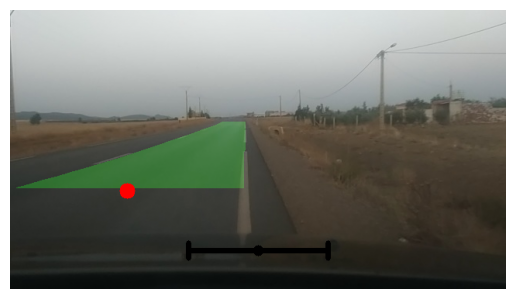

In [68]:
p = r"F:\Master\S4\yolo_test\vids\labels_projet11\projet11_277.jpg"
colored = cv2.imread(p.replace("labels_", ""))
colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)
image = cv2.imread(p)
h,w = image.shape[:2]
LANE_THRESHOLD = 90
CAR_CENTER = w//2

masks = keep_red(image)
left, right, ys,dirs = get_curvatures2(masks,[1,2],1,range=[0,-1])
out = draw_lane_zone_transp(colored, left, right, ys, opacity=.30, color=(0, 1, 0))
lane_departure_warning(left[-1], right[-1],CAR_CENTER, LANE_THRESHOLD, ys[-1], trigger_sound=False,img=out)
# draw_direction(out, dirs, 3, (0, 0, 0), -1)
# out = cv2.cvtColor((out*255).astype(np.int32), cv2.COLOR_BGR2RGB)
show_img(out,)

In [ ]:
image = cv2.imread(p)
img = keep_red(image).astype(int)
target = np.zeros(img.shape[:2])
def jiggle(img, step, mask_index, max_index=3):
    def clip(arr, index):
        len_ = len(arr)
        return (len_+index) % len_
    points = []
    flip = False
    for (index, line) in enumerate(img[::step]):
        index = index*step
        # print(index)
        indices = np.where(line == mask_index)
        if len(indices[0]) == 0:
            continue
        max = indices[0]
        max.max()
        i = max_index
        if flip:
            i = i*-1
        i = clip(max, i)
        y, x = index, max[i]
        points.append([x, y])
        flip = not flip
    return points
step = 1
for index in np.unique(img):
    if index == 0:
        continue
    points = jiggle(img, step, index, 3)
    prev = None
    for x, y in points:
        curr = (x, y)
        if prev is not None:
            cv2.line(target, prev, curr, 1, 1)
        prev = curr

h,w = img.shape[:2]
polygon_height = config.get("polygon_height")
target = target * 255
original_shape = target.shape[:2]
warped = warp_perspective(target/255, (int(h), w), polygon)
result = get_curvatures(warped, 50)
if result is None:
    show_img(warped)
_, xs, ys = result
warped = warped.astype(np.float32)/255
# if False:
warped = np.zeros((*warped.shape[:2], 3))
# warped = draw_lane_zone(warped, xs, ys, color=(0, 255, 0), draw_lines=False)





def get_dir(gray_image, draw=False, step=1):
    points = []
    for i, line in enumerate(gray_image[::step]):
        i = i * step
        ind = np.where(line > 0)
        ind = ind[0]
        if len(ind) == 0:
            continue
        mid = (ind[-1] + ind[0]) // 2, i
        if draw:
            cv2.circle(gray_image, mid, 10, 0)
        points.append(mid)
    return points




warped = warp_perspective(warped, original_shape, polygon, flip=True)
show_img(warped)

